<a href="https://colab.research.google.com/github/jjungmini/solar/blob/main/%ED%83%9C%EC%96%91%EA%B4%91_%EB%AF%B8%EC%84%B8%EB%A8%BC%EC%A7%80o_231117.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install prophet
!pip install h2o
!pip install mxnet
!pip install xlsxwriter

In [23]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import seaborn as sns


In [24]:
# 데이터 로딩
df = pd.read_excel('pvdata.xlsx')

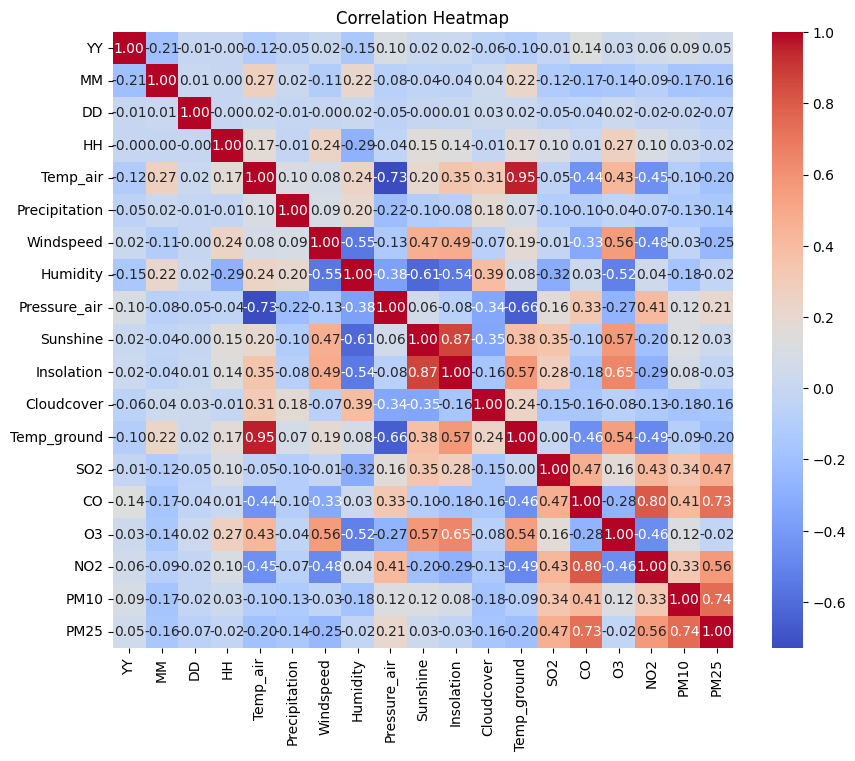

In [25]:
# 날짜를 datetime 타입으로 변환
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d-%H')

# 타겟 변수를 위한 별도의 스케일러 정의
target_scaler = MinMaxScaler()
df['solarpower'] = target_scaler.fit_transform(df[['solarpower']])

# 특성만 정규화하기 위해 Scaler 정의
scaler = MinMaxScaler()

# 특성들 간의 상관관계 계산을 위해 타겟 변수 제외

correlation_matrix = df.drop(columns=['Date', 'solarpower']).corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Solarpower 제외하고 정규화
features = df.drop(columns=['Date', 'solarpower'])
scaled_features = scaler.fit_transform(features)
df[features.columns] = scaled_features

# 훈련 데이터와 테스트 데이터로 분리
train = df[df['Date'] < '2023-04-01']
test = df[(df['Date'] >= '2022-04-01') & (df['Date'] < '2023-05-01')]

# feature selection

In [26]:
# 훈련 데이터를 이용하여 특성 선택을 위한 ElasticNetCV 모델을 생성합니다
enet_train = ElasticNetCV(
    alphas=[0.0001,0.001, 0.01, 0.1, 1, 10],        # 후보 alpha 값 리스트
    l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9],     # 후보 l1_ratio 값 리스트
    cv=5,                                   # 5-fold cross-validation 사용
    n_alphas=1000,                           # 100개의 alpha 값 생성
    max_iter=1000,                          # 최대 반복 횟수
    tol=1e-4,                               # 수렴 기준
    verbose=False,                          # 로그 출력 비활성화
    precompute='auto',                      # 자동으로 사전 계산된 Gram 행렬 결정
    selection='random',                      # 랜덤하게 특성 선택
    random_state=42
)
enet_train.fit(train.drop(columns=['Date', 'solarpower']), train['solarpower'])
# alpha 값을 출력합니다.
print('Best alpha: ', enet_train.alpha_)

# 선택된 특성만 남김
selected_features_train = train.drop(columns=['Date', 'solarpower']).columns[enet_train.coef_ != 0]
train = train[['Date', 'solarpower'] + selected_features_train.tolist()]

# 선택된 특성 출력
print("Selected features: ", selected_features_train.tolist())




Best alpha:  0.0001
Selected features:  ['YY', 'MM', 'DD', 'HH', 'Temp_air', 'Precipitation', 'Windspeed', 'Humidity', 'Pressure_air', 'Sunshine', 'Insolation', 'Cloudcover', 'Temp_ground', 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25']


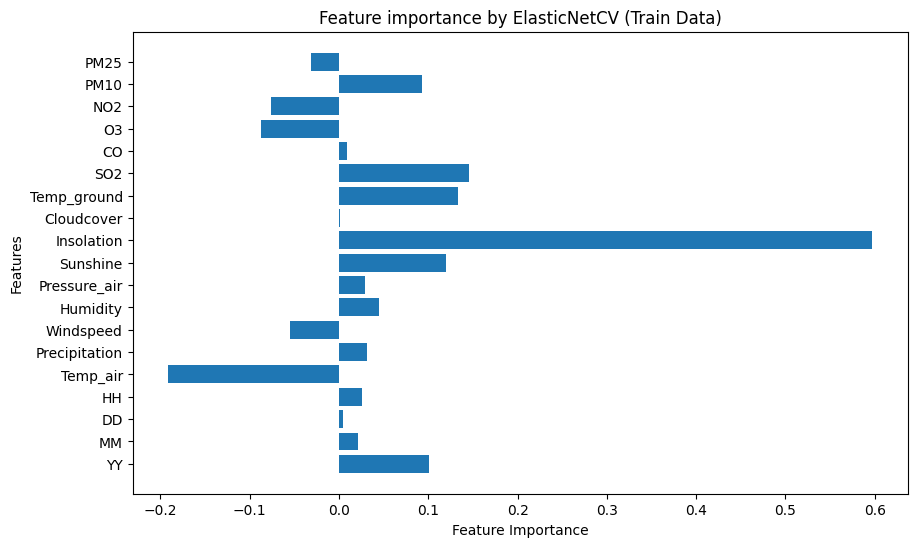

In [27]:
# ElasticNetCV의 결과를 출력합니다.
# 특성 중요도를 시각화합니다.
plt.figure(figsize=(10, 6))
plt.barh(range(len(enet_train.coef_)), enet_train.coef_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.yticks(range(len(enet_train.coef_)), enet_train.feature_names_in_)
plt.title('Feature importance by ElasticNetCV (Train Data)')
plt.show()

# AutoML 학습을 위한 데이터셋 설정

In [30]:
# H2O 라이브러리 초기화
h2o.init()

# H2O 데이터프레임으로 변환
h2o_train = h2o.H2OFrame(train.drop('Date', axis=1))

# Date 열을 제외한 특성과 타겟 변수를 정의
x = h2o_train.columns
x.remove('solarpower')

y = 'solarpower'

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,23 mins 29 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_unknownUser_q13unx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.077 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [31]:
# AutoML 설정 및 모델 훈련 (모든 파라미터를 원하는 값으로 변경하여 설정)
aml = H2OAutoML(
     max_runtime_secs=3600,     # AutoML 실행에 허용할 최대 시간 (초)
    # max_models=20,             # 생성할 최대 모델 수
    stopping_metric='RMSE',    # 조기 종료를 위한 평가 지표
    stopping_tolerance=0.01,  # 조기 종료를 위한 허용 오차
    stopping_rounds=3,         # 조기 종료를 위한 반복 횟수
    nfolds=5,                  # 교차 검증(fold)의 개수
    seed=42,                   # 랜덤 시드
    exclude_algos = ["StackedEnsemble"],

   #include_algos=['Deeplearning'], #'DRF', 'XGBoost'],  # 사용할 알고리즘들의 리스트
    keep_cross_validation_predictions=True,  # 교차 검증 예측 결과 보존 여부
    keep_cross_validation_models=False,      # 교차 검증 모델 보존 여부
    keep_cross_validation_fold_assignment=False,  # 교차 검증 폴드 할당 보존 여부
    sort_metric='RMSE',        # 성능 측정 기준
    export_checkpoints_dir=None  # 모델 체크포인트를 내보낼 디렉토리
)

aml.train(x=x, y=y, training_frame=h2o_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_2_20231117_74521_model_10


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    87                 87                          438160                 0            13           12.2529       1             733           395.736

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.00016765527891148525
RMSE: 0.012948176663588015
MAE: 0.007411435002054953
RMSLE: 0.010186281101966762
Mean Residual Deviance: 0.00016765527891148525

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.0005131362943244152
RMSE: 0.0226525118767084
MAE: 0.012406315592183106
RMSLE: 0.017588269317766716
Mean Residual Deviance: 0.0005131362943244152

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.0124063    9.76918e-05  0.0122596     0.0125074     0.0124148     0.0124781     0.0123718
mean_residual_deviance  0.000513136  5.79965e-06  0.000507951   0.000521684   0.000511354   0.000516229   0.000508463
mse                     0.000513136  5.79965e-06  0.000507951   0.000521684   0.000511354   0.000516229   0.000508463
r2                      0.985721     0.000149706  0.985876      0.985542      0.985779      0.985582      0.985825
residual_deviance       0.000513136  5.79965e-06  0.000507951   0.000521684   0.000511354   0.000516229   0.000508463
rmse                    0.0226522    0.000127828  0.0225378     0.0228404     0.0226131     0.0227207     0.0225491
rmsle                   0.0175881    8.75217e-05  0.0175071     0.0177262     0.0175526     0.0176192     0.0175354

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2023-11-17 08:28:26  7 min 48.737 sec  0                  0.189566         0.150789        0.0359354
    2023-11-17 08:28:27  7 min 49.153 sec  5                  0.114687         0.0905212       0.013153
    2023-11-17 08:28:27  7 min 49.531 sec  10                 0.0708816        0.0552138       0.00502421
    2023-11-17 08:28:27  7 min 49.925 sec  15                 0.0456837        0.0348169       0.002087
    2023-11-17 08:28:28  7 min 50.330 sec  20                 0.0316262        0.0232594       0.00100022
    2023-11-17 08:28:28  7 min 50.702 sec  25                 0.0241808        0.0168307       0.00058471
    2023-11-17 08:28:29  7 min 51.086 sec  30                 0.0202372        0.0131702       0.000409543
    2023-11-17 08:28:29  7 min 51.448 sec  35                 0.0180864        0.0110905       0.000327118
    2023-11-17 08:28:29  7 min 51.810 sec  40                 0.0167723        0.00983066      0.000281309
    2023-11-17 08:28:30  7 min 52.148 sec  45                 0.0159721        0.0091231       0.000255109
    2023-11-17 08:28:30  7 min 52.486 sec  50                 0.0153184        0.00864537      0.000234654
    2023-11-17 08:28:30  7 min 52.800 sec  55                 0.0148229        0.00833213      0.000219718
    2023-11-17 08:28:31  7 min 53.154 sec  60                 0.014319         0.00807134      0.000205034
    2023-11-17 08:28:31  7 min 53.476 sec  65                 0.0139719        0.00789508      0.000195215
    2023-11-17 08:28:31  7 min 53.797 sec  70                 0.0136021        0.007722        0.000185017
    2023-11-1

# Automl 학습결과 확인

In [32]:
# AutoML 결과 확인 (모든 모델 출력)
lb = aml.leaderboard
print(lb)

# Leaderboard 데이터를 Pandas DataFrame으로 변환
leaderboard_df = lb.as_data_frame()

# 모든 모델의 성능 순위를 변수로 저장
for idx, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    rank = idx + 1
    exec(f"model_rank_{rank} = h2o.get_model('{model_id}')")

# 모든 모델의 성능 순위 출력
print("\n<< 모든 모델의 성능 순위 >>")
for idx, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    rank = idx + 1
    print(f"Model: {model_id}, Rank: {rank}")


model_id                                              rmse          mse        mae      rmsle    mean_residual_deviance
GBM_grid_1_AutoML_2_20231117_74521_model_10      0.0226525  0.000513136  0.0124063  0.0175883               0.000513136
GBM_grid_1_AutoML_2_20231117_74521_model_5       0.0230637  0.000531933  0.012726   0.0179162               0.000531933
GBM_grid_1_AutoML_2_20231117_74521_model_2       0.0231144  0.000534277  0.0123864  0.0179504               0.000534277
GBM_3_AutoML_2_20231117_74521                    0.0233916  0.000547165  0.0130701  0.0181995               0.000547165
GBM_grid_1_AutoML_2_20231117_74521_model_9       0.0234722  0.000550942  0.0131338  0.0181788               0.000550942
GBM_1_AutoML_2_20231117_74521                    0.0234765  0.000551145  0.0132945  0.0181988               0.000551145
GBM_grid_1_AutoML_2_20231117_74521_model_23      0.0234782  0.000551224  0.0132235  0.0182065               0.000551224
XGBoost_grid_1_AutoML_2_20231117_74521_m

In [33]:
# 순위별로 모델에 대한 세부 정보 출력
# n등의 모델을 출력하려면 : print(model_rank_n)
print(model_rank_1)

Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_2_20231117_74521_model_10


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    87                 87                          438160                 0            13           12.2529       1             733           395.736

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.00016765527891148525
RMSE: 0.012948176663588015
MAE: 0.007411435002054953
RMSLE: 0.010186281101966762
Mean Residual Deviance: 0.00016765527891148525

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.0005131362943244152
RMSE: 0.0226525118767084
MAE: 0.012406315592183106
RMSLE: 0.017588269317766716
Mea

In [34]:
# AutoML 결과 확인 (모든 모델 출력)
lb = aml.leaderboard
print(lb)

# Leaderboard 데이터를 Pandas DataFrame으로 변환
leaderboard_df = lb.as_data_frame()

# Excel 파일 생성
writer = pd.ExcelWriter('train_result.xlsx', engine='xlsxwriter')

# 모든 모델의 파라미터 정보를 저장하는 새로운 열을 추가합니다.
all_parameters = []
for index, row in leaderboard_df.iterrows():
    model_id = row['model_id']
    model = h2o.get_model(model_id)
    model_params = model.params
    all_parameters.append(model_params)

leaderboard_df['Parameters'] = all_parameters

# DataFrame을 첫 번째 시트로 저장합니다.
leaderboard_df.to_excel(writer, sheet_name='Leaderboard', index=True)



# 엑셀 파일 저장
writer.save()


model_id                                              rmse          mse        mae      rmsle    mean_residual_deviance
GBM_grid_1_AutoML_2_20231117_74521_model_10      0.0226525  0.000513136  0.0124063  0.0175883               0.000513136
GBM_grid_1_AutoML_2_20231117_74521_model_5       0.0230637  0.000531933  0.012726   0.0179162               0.000531933
GBM_grid_1_AutoML_2_20231117_74521_model_2       0.0231144  0.000534277  0.0123864  0.0179504               0.000534277
GBM_3_AutoML_2_20231117_74521                    0.0233916  0.000547165  0.0130701  0.0181995               0.000547165
GBM_grid_1_AutoML_2_20231117_74521_model_9       0.0234722  0.000550942  0.0131338  0.0181788               0.000550942
GBM_1_AutoML_2_20231117_74521                    0.0234765  0.000551145  0.0132945  0.0181988               0.000551145
GBM_grid_1_AutoML_2_20231117_74521_model_23      0.0234782  0.000551224  0.0132235  0.0182065               0.000551224
XGBoost_grid_1_AutoML_2_20231117_74521_m

<ipython-input-34-d0d42f4991af>:27: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


# 모델 학습 결과 시각화 용

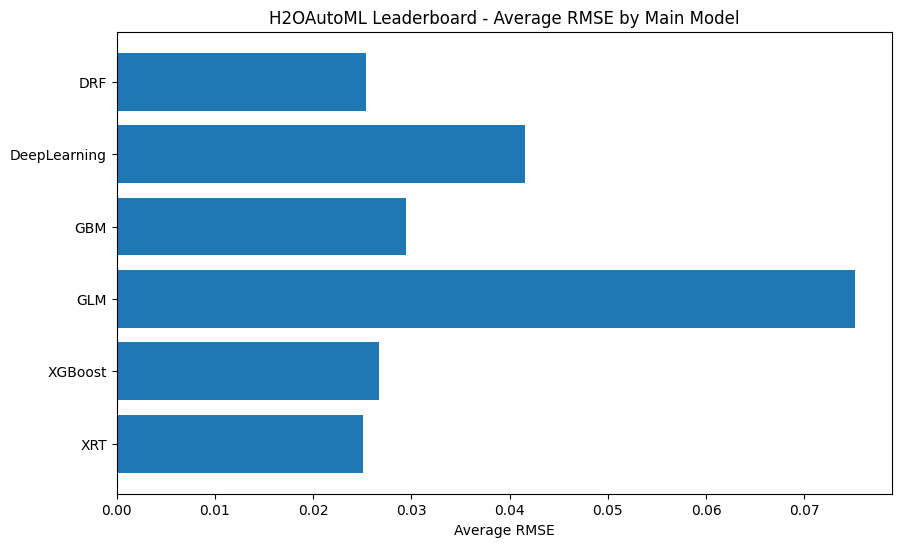

In [35]:
import matplotlib.pyplot as plt

# 메인 모델(model_id 앞의 첫 단어)을 기준으로 데이터를 그룹화
grouped_leaderboard = leaderboard_df.groupby(leaderboard_df['model_id'].str.split('_').str[0])

# 각 그룹별 평균값 계산
group_means = grouped_leaderboard['rmse'].mean()

# 그룹 평균값을 시각화하여 비교
plt.figure(figsize=(10, 6))
plt.barh(group_means.index, group_means.values)
plt.xlabel('Average RMSE')
plt.title('H2OAutoML Leaderboard - Average RMSE by Main Model')
plt.gca().invert_yaxis()  # 모델 순위를 높은 순서대로 표시
plt.show()


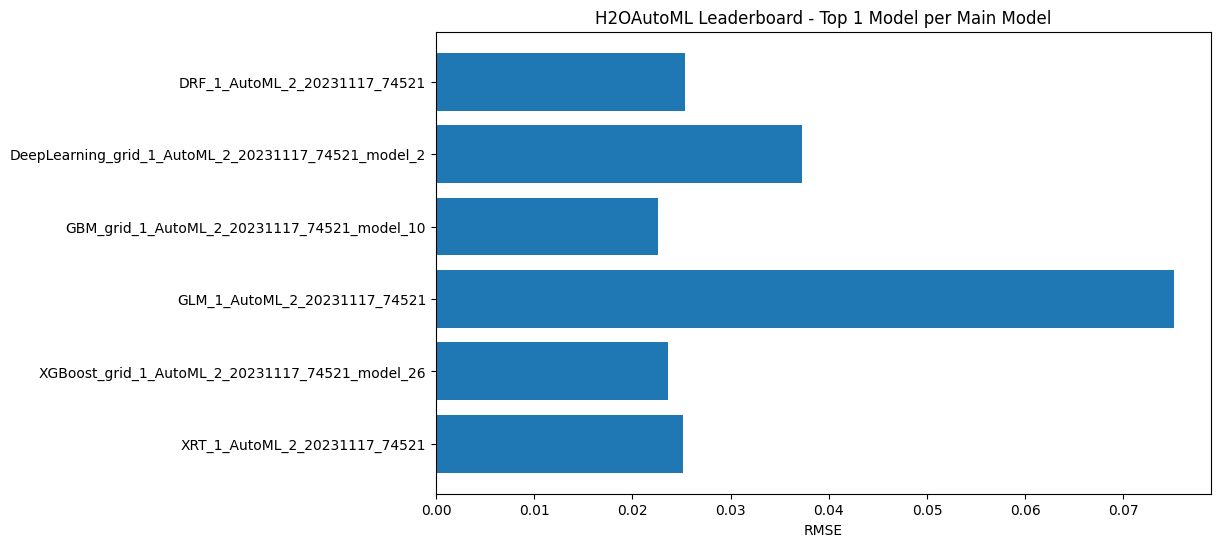

In [36]:
import matplotlib.pyplot as plt

# 메인 모델(model_id 앞의 첫 단어)을 기준으로 데이터를 그룹화
grouped_leaderboard = leaderboard_df.groupby(leaderboard_df['model_id'].str.split('_').str[0])

# 각 그룹별 1위 모델 선택 (가장 낮은 RMSE 값을 가진 모델)
top_1_models = grouped_leaderboard.apply(lambda group: group.nsmallest(1, 'rmse'))

# 메인 모델별 1위 모델의 RMSE를 시각화하여 비교
plt.figure(figsize=(10, 6))
plt.barh(top_1_models['model_id'], top_1_models['rmse'])
plt.xlabel('RMSE')
plt.title('H2OAutoML Leaderboard - Top 1 Model per Main Model')
plt.gca().invert_yaxis()  # 모델 순위를 높은 순서대로 표시
plt.show()


# best 모델 출력하고, 예측을 위한 df 변환

In [37]:
# 가장 성능이 좋은 모델 선택
best_model = aml.leader

# 선택된 특성 출력
print("Best model is: ", best_model)

Best model is:  Model Details
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_2_20231117_74521_model_10


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    87                 87                          438160                 0            13           12.2529       1             733           395.736

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.00016765527891148525
RMSE: 0.012948176663588015
MAE: 0.007411435002054953
RMSLE: 0.010186281101966762
Mean Residual Deviance: 0.00016765527891148525

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 0.0005131362943244152
RMSE: 0.0226525118767084
MAE: 0.012406315592183106
RMSLE: 0.017588

In [38]:
# MAPE 계산 함수 정의
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 테스트 데이터를 H2O 데이터프레임으로 변환
h2o_test = h2o.H2OFrame(test.drop('Date', axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# 원하는 rank의 모델 사용하여 test data 예측 수행

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
평균 제곱 오차 (MSE): 42.330216986925755
평균 절대 오차 (MAE): 3.4457552618979292
결정 계수 (R2): 0.9942572024043591
평균 절대 백분율 오차 (MAPE): inf
평균 제곱근 오차 (RMSE): 6.506167611345849


<ipython-input-38-b056e2400552>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


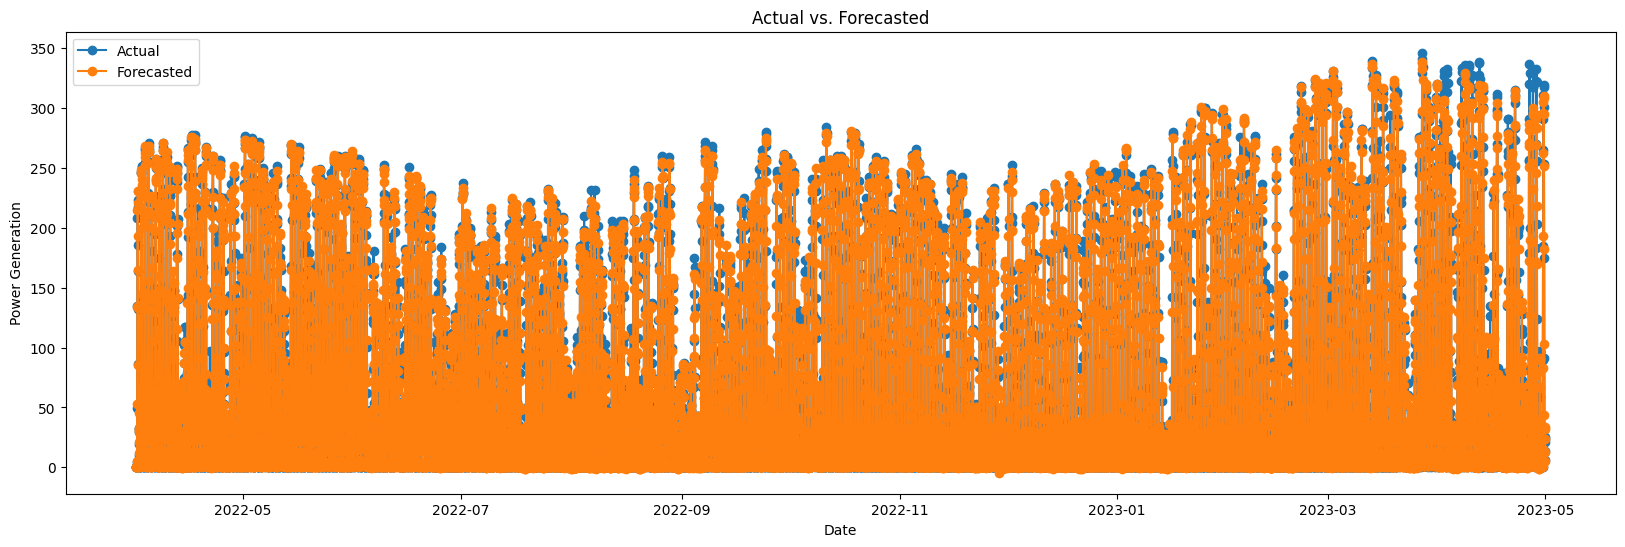

In [40]:
# 원하는 rank의 모델을 사용하여 예측 수행
predictions = model_rank_1.predict(h2o_test) #model_rank_n
predictions = predictions.as_data_frame()

# 예측된 값을 원래 스케일로 역변환
predictions = target_scaler.inverse_transform(predictions)

# 테스트 데이터셋의 실제 타겟 변수 값을 가져옴
actual_values = test['solarpower'].values.reshape(-1, 1)
actual_values = target_scaler.inverse_transform(actual_values)

# 평가 지표 계산
mse = mean_squared_error(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)
mape = mean_absolute_percentage_error(actual_values, predictions)
rmse = np.sqrt(mse)

# 평가 지표 출력
print("평균 제곱 오차 (MSE):", mse)
print("평균 절대 오차 (MAE):", mae)
print("결정 계수 (R2):", r2)
print("평균 절대 백분율 오차 (MAPE):", mape)
print("평균 제곱근 오차 (RMSE):", rmse)

# 실제 값과 예측값 시각화
plt.figure(figsize=(20, 6))
plt.plot(test['Date'], actual_values, label='Actual', marker='o')
plt.plot(test['Date'], predictions, label='Forecasted', marker='o')
plt.xlabel('Date')
plt.ylabel('Power Generation')
plt.title('Actual vs. Forecasted')
plt.legend()
plt.show()


# (안해도됨) best model 예측

In [ ]:
# 가장 좋은 모델인 best_model을 사용하여 예측 수행
predictions = best_model.predict(h2o_test)
predictions = predictions.as_data_frame()

# 예측된 값을 원래 스케일로 역변환
predictions = target_scaler.inverse_transform(predictions)

# 테스트 데이터셋의 실제 타겟 변수 값을 가져옴
actual_values = test['Solarpower'].values.reshape(-1, 1)
actual_values = target_scaler.inverse_transform(actual_values)

# 평가 지표 계산
mse = mean_squared_error(actual_values, predictions)
mae = mean_absolute_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)
mape = mean_absolute_percentage_error(actual_values, predictions)
rmse = np.sqrt(mse)

# 평가 지표 출력
print("평균 제곱 오차 (MSE):", mse)
print("평균 절대 오차 (MAE):", mae)
print("결정 계수 (R2):", r2)
print("평균 절대 백분율 오차 (MAPE):", mape)
print("평균 제곱근 오차 (RMSE):", rmse)

# 실제 값과 예측값 시각화
plt.figure(figsize=(10, 6))
plt.plot(test['Date'], actual_values, label='Actual', marker='o')
plt.plot(test['Date'], predictions, label='Forecasted', marker='o')
plt.xlabel('Date')
plt.ylabel('Power Generation')
plt.title('Actual vs. Forecasted')
plt.legend()
plt.show()
